In [1]:
# --- Standard libraries ---
import os
import joblib

# --- Data manipulation and processing ---
import pandas as pd
import numpy as np

# --- Machine learning & preprocessing ---
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report

# --- Deep learning ---
import torch
import torch.nn.functional as F

# --- Graph-based computations ---
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import networkx as nx

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# --- Define paths and initialize variables ---
folder_path = "../data/raw/features/features"
annotations_path = "../data/raw/features/annotations/static_annotations_averaged_songs_1_2000.csv"
all_features = {}

In [3]:
# --- Aggregate features per song ---
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath, sep=';')
        
        # Select numerical columns
        numeric_df = df.select_dtypes(include=['number'])
        
        # Remove unnecessary columns
        if 'frameTime' in numeric_df.columns:
            numeric_df = numeric_df.drop(columns=['frameTime'])
        
        cols_to_remove = [col for col in numeric_df.columns if '_de_' in col]
        numeric_df = numeric_df.drop(columns=cols_to_remove)
        
        # Calculate feature means and standard deviations
        feature_means = numeric_df.mean()
        feature_stds = numeric_df.std()
        
        # Combine the mean and standard deviation into one feature vector
        feature_vector = pd.concat([feature_means, feature_stds], axis=0)
        
        # Use the file name (track_id) as the index
        track_id = os.path.splitext(filename)[0]
        all_features[track_id] = feature_vector

# Create a DataFrame from the aggregated features
features_df = pd.DataFrame.from_dict(all_features, orient='index')

In [4]:
# --- Load annotations ---
annotations_df = pd.read_csv(annotations_path)

# Strip any whitespace from column names
annotations_df.columns = annotations_df.columns.str.strip()

# --- Step 3: Prepare annotations for merging ---
# Rename 'song_id' to 'track_id' for merging
annotations_df = annotations_df.rename(columns={'song_id': 'track_id'})

# Reset index on features_df so 'track_id' is a column instead of index
features_df = features_df.reset_index().rename(columns={'index': 'track_id'})

# Ensure 'track_id' columns are strings and stripped (optional but safer)
features_df['track_id'] = features_df['track_id'].astype(str).str.strip()
annotations_df['track_id'] = annotations_df['track_id'].astype(str).str.strip()

In [5]:
# --- Merge features with annotations on 'track_id' ---
merged_df = pd.merge(features_df, annotations_df, on='track_id', how='inner')

# Print column names to verify the merge
print(merged_df.columns.tolist())

['track_id', 'F0final_sma_stddev', 'F0final_sma_amean', 'voicingFinalUnclipped_sma_stddev', 'voicingFinalUnclipped_sma_amean', 'jitterLocal_sma_stddev', 'jitterLocal_sma_amean', 'jitterDDP_sma_stddev', 'jitterDDP_sma_amean', 'shimmerLocal_sma_stddev', 'shimmerLocal_sma_amean', 'logHNR_sma_stddev', 'logHNR_sma_amean', 'audspec_lengthL1norm_sma_stddev', 'audspec_lengthL1norm_sma_amean', 'audspecRasta_lengthL1norm_sma_stddev', 'audspecRasta_lengthL1norm_sma_amean', 'pcm_RMSenergy_sma_stddev', 'pcm_RMSenergy_sma_amean', 'pcm_zcr_sma_stddev', 'pcm_zcr_sma_amean', 'audSpec_Rfilt_sma[0]_stddev', 'audSpec_Rfilt_sma[0]_amean', 'audSpec_Rfilt_sma[1]_stddev', 'audSpec_Rfilt_sma[1]_amean', 'audSpec_Rfilt_sma[2]_stddev', 'audSpec_Rfilt_sma[2]_amean', 'audSpec_Rfilt_sma[3]_stddev', 'audSpec_Rfilt_sma[3]_amean', 'audSpec_Rfilt_sma[4]_stddev', 'audSpec_Rfilt_sma[4]_amean', 'audSpec_Rfilt_sma[5]_stddev', 'audSpec_Rfilt_sma[5]_amean', 'audSpec_Rfilt_sma[6]_stddev', 'audSpec_Rfilt_sma[6]_amean', 'audSpec

In [6]:
# --- Normalize valence and arousal means to [0,1] for thresholding ---
val_min, val_max = merged_df['valence_mean'].min(), merged_df['valence_mean'].max()
aro_min, aro_max = merged_df['arousal_mean'].min(), merged_df['arousal_mean'].max()

# Normalize valence and arousal columns
merged_df['valence_norm'] = (merged_df['valence_mean'] - val_min) / (val_max - val_min)
merged_df['arousal_norm'] = (merged_df['arousal_mean'] - aro_min) / (aro_max - aro_min)

In [7]:
# --- Define function to assign mood ---
def assign_mood(valence, arousal, threshold=0.5):
    if valence >= threshold and arousal >= threshold:
        return 'happy'
    elif valence >= threshold and arousal < threshold:
        return 'calm'
    elif valence < threshold and arousal >= threshold:
        return 'angry'
    else:
        return 'sad'

# Apply the function to assign mood to each row in the merged DataFrame
merged_df['mood'] = merged_df.apply(lambda row: assign_mood(row['valence_norm'], row['arousal_norm']), axis=1)

# Print the first few rows to verify
print(merged_df[['track_id', 'valence_mean', 'arousal_mean', 'valence_norm', 'arousal_norm', 'mood']].head(10))

  track_id  valence_mean  arousal_mean  valence_norm  arousal_norm   mood
0       10           4.0           4.7      0.352941      0.476923    sad
1     1000           6.8           5.6      0.764706      0.615385  happy
2     1001           4.4           3.8      0.411765      0.338462    sad
3     1002           4.5           3.2      0.426471      0.246154    sad
4     1003           5.3           3.3      0.544118      0.261538   calm
5     1004           3.8           4.7      0.323529      0.476923    sad
6     1005           5.4           5.1      0.558824      0.538462  happy
7     1006           4.6           4.4      0.441176      0.430769    sad
8     1007           5.2           5.4      0.529412      0.584615  happy
9     1008           6.0           5.4      0.647059      0.584615  happy


In [8]:
# --- Preprocessing: Exclude irrelevant columns and prepare feature columns ---
# Exclude columns that won't be used for modeling
exclude_cols = [
    'track_id', 'valence_mean', 'valence_std',
    'arousal_mean', 'arousal_std', 'valence_norm',
    'arousal_norm', 'mood'
]

# Feature columns are all columns except the excluded ones
feature_cols = [col for col in merged_df.columns if col not in exclude_cols]

# Extract features (X) and labels (y)
X = merged_df[feature_cols].values
labels = merged_df['mood'].values

# --- Normalize features ---
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [9]:
# --- Compute similarity matrix and encode labels ---
num_nodes = X_normalized.shape[0]
similarity_matrix = cosine_similarity(X_normalized)

# Encode labels to numerical format
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [10]:
# --- Compute class frequencies and define k values per class ---
unique_classes, counts = np.unique(labels_encoded, return_counts=True)
total_samples = len(labels_encoded)
class_freq = {c: count / total_samples for c, count in zip(unique_classes, counts)}

# Define min and max k
min_k = 15  
max_k = 35 

# Compute k per class based on inverse frequency
k_per_class = {}
for c in unique_classes:
    freq = class_freq[c]
    k_per_class[c] = int(min_k + (1 - freq) * (max_k - min_k))

print("k neighbors per class:", k_per_class)

k neighbors per class: {np.int64(0): 31, np.int64(1): 32, np.int64(2): 27, np.int64(3): 27}


In [11]:
# --- Adjust similarity by mood match factor and find top-k neighbors ---
adjusted_similarity = similarity_matrix.copy()

# Boost similarity for nodes with the same mood
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if labels_encoded[i] == labels_encoded[j]:
            adjusted_similarity[i, j] *= 2
            adjusted_similarity[j, i] = adjusted_similarity[i, j]

# Find top-k neighbors per node with dynamic k by class
top_k_neighbors = []
for i in range(num_nodes):
    node_class = labels_encoded[i]
    k_for_node = k_per_class[node_class]

    sim_scores = adjusted_similarity[i].copy()
    sim_scores[i] = -1  # exclude self
    neighbors = np.argsort(sim_scores)[::-1][:k_for_node]
    top_k_neighbors.append(set(neighbors))

In [12]:
# --- Build mutual kNN graph ---
mutual_knn_edges = set()

# Add edges between mutual neighbors
for i in range(num_nodes):
    for j in top_k_neighbors[i]:
        if i in top_k_neighbors[j]:  # mutual condition
            edge = tuple(sorted((i, j)))
            mutual_knn_edges.add(edge)

# Add extra edges for minority class nodes
minority_class_nodes = [i for i in range(num_nodes) if class_freq[labels_encoded[i]] < 0.3]

for node in minority_class_nodes:
    sim_scores = adjusted_similarity[node].copy()
    sim_scores[node] = -1  # Exclude self
    neighbors = np.argsort(sim_scores)[::-1][:5]  # Get top-5 neighbors
    for neighbor in neighbors:
        mutual_knn_edges.add(tuple(sorted((node, neighbor))))

print(f"Mutual kNN graph edges before MST: {len(mutual_knn_edges)}")

Mutual kNN graph edges before MST: 13982


In [13]:
# --- Create graph and add MST edges if necessary ---
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(mutual_knn_edges)

# Check connectivity and add MST edges if disconnected
if not nx.is_connected(G):
    print("Mutual kNN graph not connected, adding MST edges for connectivity...")

    distance_matrix = 1 - similarity_matrix  # Use original similarity for MST
    G_full = nx.Graph()
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            G_full.add_edge(i, j, weight=distance_matrix[i, j])

    mst = nx.minimum_spanning_tree(G_full)

    for edge in mst.edges():
        if not G.has_edge(*edge):
            G.add_edge(*edge)

print(f"Final graph edges after MST: {G.number_of_edges()}")
print(f"Is final graph connected? {nx.is_connected(G)}")

Mutual kNN graph not connected, adding MST edges for connectivity...
Final graph edges after MST: 15002
Is final graph connected? True


In [14]:
# --- Prepare PyTorch Geometric data object ---
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
X_tensor = torch.tensor(X_normalized, dtype=torch.float)
labels_tensor = torch.tensor(labels_encoded, dtype=torch.long)

data = Data(x=X_tensor, edge_index=edge_index, y=labels_tensor)
print(f"Data object with mutual kNN + MST graph: {data}")

Data object with mutual kNN + MST graph: Data(x=[1802, 210], edge_index=[2, 15002], y=[1802])


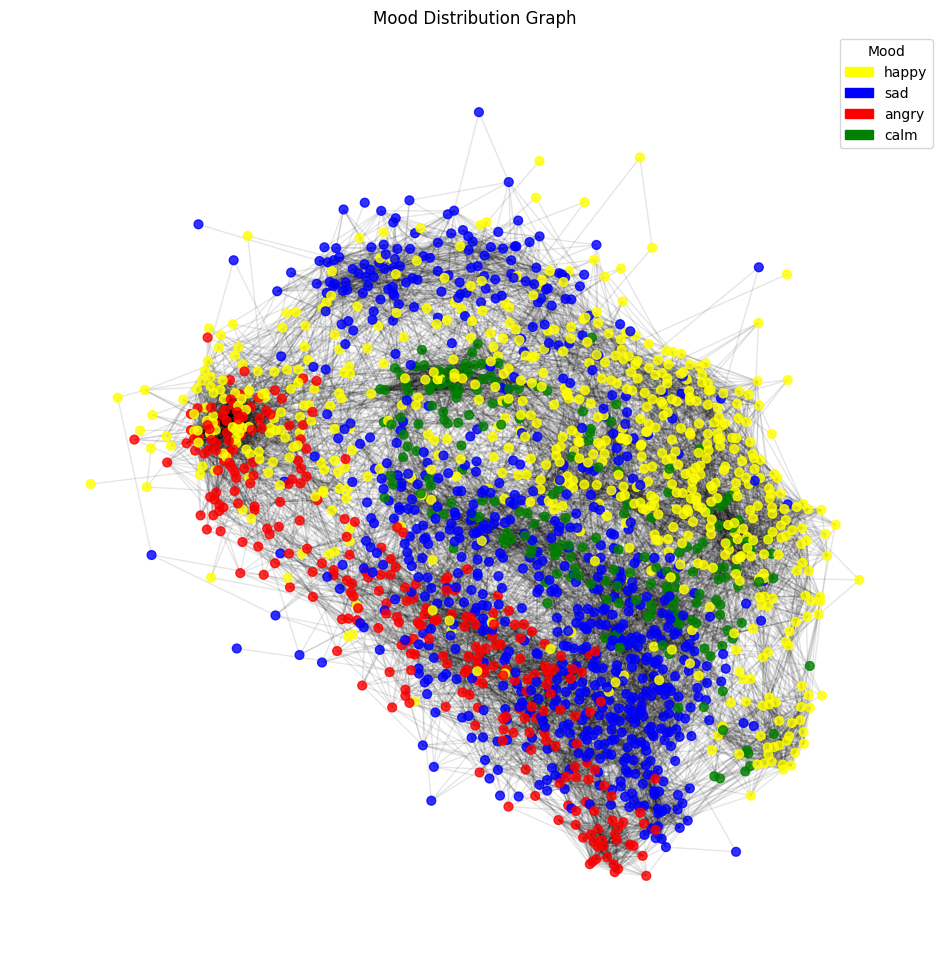

In [15]:
# --- Visualize graph colored by mood ---
mood_colors = {
    'happy': 'yellow',
    'sad': 'blue',
    'angry': 'red',
    'calm': 'green',
}

node_colors = [mood_colors.get(mood, 'gray') for mood in labels]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42, k=0.15)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=40, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1)

# Add legend
legend_handles = [mpatches.Patch(color=color, label=mood) for mood, color in mood_colors.items()]
plt.legend(handles=legend_handles, title="Mood", loc="upper right")

plt.title("Mood Distribution Graph")
plt.axis('off')
plt.show()

In [16]:
# --- Exclude track IDs for interactive testing and split data into train, validation, and test sets ---
excluded_track_ids = ['48','3','116','386','47','324','646','691','634','329','656',
                      '622','152','637','8','174','769','149','278','54','488','996','113','1390','2006']

# Get all track IDs from the merged dataframe
all_track_ids = merged_df['track_id'].astype(str).tolist()

# Identify the indices of tracks to exclude
excluded_indices = [i for i, tid in enumerate(all_track_ids) if tid in excluded_track_ids]
included_indices = [i for i in range(len(all_track_ids)) if i not in excluded_indices]

In [17]:
# --- Split the data into training, validation, and test sets ---
labels_np = labels_encoded  # Aligned with merged_df

# Split the data (80% train+val, 20% test) while stratifying by label
train_val_idx, test_idx_included = train_test_split(
    included_indices, test_size=0.2, random_state=42, stratify=labels_np[included_indices])

# Split train+val data into 75% train, 25% validation
train_idx, val_idx = train_test_split(
    train_val_idx, test_size=0.25, random_state=42, stratify=labels_np[train_val_idx])

# Combine the excluded indices with the test set
test_idx = list(test_idx_included) + excluded_indices

In [18]:
# --- Create masks for train, validation, and test sets ---
num_nodes = len(all_track_ids)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Set the corresponding masks to True for each set
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# Assign masks to the data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [19]:
# --- Apply feature scaling and save the scaler ---
# Exclude non-feature columns (e.g., mood, track_id)
feature_cols = [col for col in merged_df.columns if col not in [
    'valence_mean', 'valence_std', 'arousal_mean', 'arousal_std', 
    'valence_norm', 'arousal_norm', 'mood', 'track_id'
]]

# Extract the feature values
features = merged_df[feature_cols].values

# Apply StandardScaler to scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Save the scaler to disk for future use
joblib.dump(scaler, '../models/scaler.save')

# Assign the scaled features to the data object
data.x = torch.tensor(features_scaled, dtype=torch.float)

In [20]:
# --- Move data to device (GPU/CPU) ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

In [21]:
# --- Save edge_index for future app use ---
# Assuming edge_index has been prepared earlier
torch.save(data.edge_index.cpu(), '../models/edge_index.pt')

In [22]:
# --- Define the GraphSAGE model ---
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.7):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [23]:
# --- Define functions for training and evaluating the model ---
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits[mask].argmax(dim=1)
        true = data.y[mask].cpu()
        pred = preds.cpu()

        acc = accuracy_score(true, pred)
        f1_macro = f1_score(true, pred, average='macro')
        f1_weighted = f1_score(true, pred, average='weighted')
    return acc, f1_macro, f1_weighted

In [24]:
# --- Initialize model, optimizer, and training loop ---
hidden_dim = 32
lr = 0.01
dropout = 0.7
num_epochs = 500

# Instantiate the model
model = GraphSAGE(
    input_dim=data.num_node_features,
    hidden_dim=hidden_dim,
    output_dim=len(torch.unique(labels_tensor)),
    dropout=dropout).to(device)

# Set up optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

# Lists to track performance
val_acc_history = []
test_acc_history = []
best_val_acc = 0
best_test_acc = 0

val_f1_macro_history = []
val_f1_weighted_history = []
test_f1_macro_history = []
test_f1_weighted_history = []

# Training loop
for epoch in range(1, num_epochs + 1):
    loss = train(model, optimizer)
    
    val_acc, val_f1_macro, val_f1_weighted = evaluate(model, data.val_mask)
    test_acc, test_f1_macro, test_f1_weighted = evaluate(model, data.test_mask)

    val_acc_history.append(val_acc)
    test_acc_history.append(test_acc)
    val_f1_macro_history.append(val_f1_macro)
    test_f1_macro_history.append(test_f1_macro)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc

    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | Val F1: {val_f1_macro:.4f} | "
              f"Test Acc: {test_acc:.4f} | Test F1: {test_f1_macro:.4f}")

Epoch 001 | Loss: 1.5828 | Val Acc: 0.4354 | Val F1: 0.3257 | Test Acc: 0.4147 | Test F1: 0.3110
Epoch 010 | Loss: 0.9116 | Val Acc: 0.6938 | Val F1: 0.4880 | Test Acc: 0.6850 | Test F1: 0.4538
Epoch 020 | Loss: 0.7064 | Val Acc: 0.7219 | Val F1: 0.5818 | Test Acc: 0.7428 | Test F1: 0.5912
Epoch 030 | Loss: 0.5840 | Val Acc: 0.7669 | Val F1: 0.6592 | Test Acc: 0.7822 | Test F1: 0.6515
Epoch 040 | Loss: 0.5171 | Val Acc: 0.8287 | Val F1: 0.7654 | Test Acc: 0.8451 | Test F1: 0.7782
Epoch 050 | Loss: 0.4462 | Val Acc: 0.8427 | Val F1: 0.7925 | Test Acc: 0.8583 | Test F1: 0.8081
Epoch 060 | Loss: 0.4106 | Val Acc: 0.8708 | Val F1: 0.8405 | Test Acc: 0.8871 | Test F1: 0.8548
Epoch 070 | Loss: 0.3552 | Val Acc: 0.8820 | Val F1: 0.8558 | Test Acc: 0.8924 | Test F1: 0.8648
Epoch 080 | Loss: 0.3412 | Val Acc: 0.8876 | Val F1: 0.8616 | Test Acc: 0.8976 | Test F1: 0.8675
Epoch 090 | Loss: 0.2949 | Val Acc: 0.8933 | Val F1: 0.8719 | Test Acc: 0.9134 | Test F1: 0.8948
Epoch 100 | Loss: 0.3076 | Val

In [25]:
# --- Final evaluation and save model ---
mean_val_acc = np.mean(val_acc_history)
mean_test_acc = np.mean(test_acc_history)

print(f"Training with hidden_dim={hidden_dim}, lr={lr}, dropout={dropout}")
print(f"Mean Val Acc: {mean_val_acc:.4f}, Mean Test Acc: {mean_test_acc:.4f}")
print(f"Mean Val F1 (macro): {np.mean(val_f1_macro_history):.4f}, Mean Test F1 (macro): {np.mean(test_f1_macro_history):.4f}")
print(f"Best Val Acc: {best_val_acc:.4f}, Corresponding Test Acc: {best_test_acc:.4f}")

# Save the trained model, label encoder, and other results
torch.save(model.state_dict(), '../models/graphsage_model.pth')
np.save('../models/le_classes.npy', le.classes_)

# Save merged features with track IDs and feature columns
merged_df[['track_id'] + feature_cols + ['mood']].to_csv('../models/merged_features.csv', index=False)

# Save node order used for feature matrix
sorted_track_ids = merged_df['track_id'].astype(str).tolist()
np.save('../models/sorted_track_ids.npy', np.array(sorted_track_ids))

# Save feature columns used
import json
with open('../models/feature_columns.json', 'w') as f:
    json.dump(feature_cols, f)

Training with hidden_dim=32, lr=0.01, dropout=0.7
Mean Val Acc: 0.9004, Mean Test Acc: 0.9243
Mean Val F1 (macro): 0.8747, Mean Test F1 (macro): 0.9023
Best Val Acc: 0.9438, Corresponding Test Acc: 0.9554


Partea de cod care nu are accuracy bun, dar incearca sa invete fara bias

Graph not connected. Adding MST edges for connectivity...
Final graph edges: 13395
Is final graph connected? True
GMM-PCA Graph PyG Data: Data(x=[1802, 210], edge_index=[2, 13395], y=[1802])


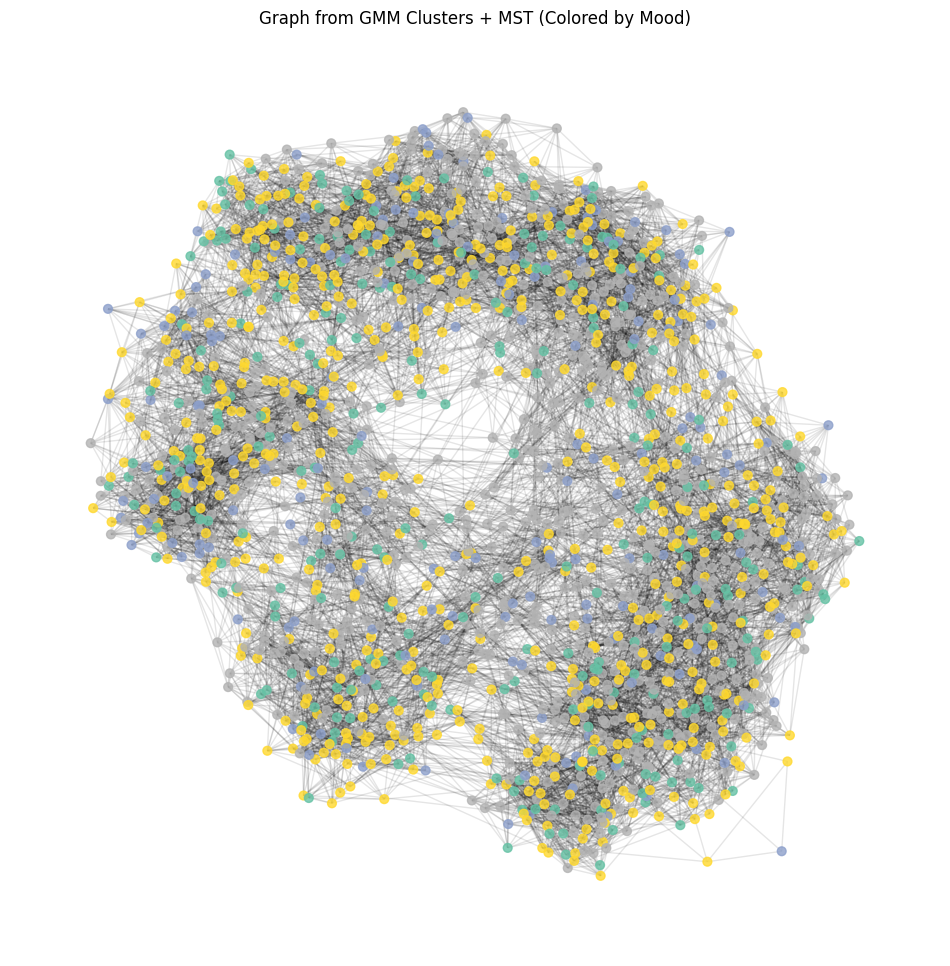

In [26]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import Data

# === Prepare features ===
exclude_cols = [
    'track_id', 'valence_mean', 'valence_std',
    'arousal_mean', 'arousal_std', 'valence_norm',
    'arousal_norm', 'mood'
]

feature_cols = [col for col in merged_df.columns if col not in exclude_cols]
X = merged_df[feature_cols].values
labels = merged_df['mood'].values

# Normalize
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_tensor = torch.tensor(labels_encoded, dtype=torch.long)
num_nodes = X.shape[0]

# === Reduce dimensions using PCA ===
pca = PCA(n_components=15, random_state=42)
X_reduced = pca.fit_transform(X_normalized)

# === Fit GMM and assign clusters ===
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
cluster_labels = gmm.fit_predict(X_reduced)

# === Build graph from shared clusters ===
G = nx.Graph()
G.add_nodes_from(range(num_nodes))

# Connect songs in the same cluster
for cluster_id in np.unique(cluster_labels):
    cluster_nodes = np.where(cluster_labels == cluster_id)[0]
    if len(cluster_nodes) < 2:
        continue  # skip tiny clusters

    # Use cosine similarity within cluster to build edges
    cluster_feats = X_reduced[cluster_nodes]
    sim_matrix = cosine_similarity(cluster_feats)

    for i, node_i in enumerate(cluster_nodes):
        # Connect to top-k most similar within cluster
        k = min(10, len(cluster_nodes) - 1)
        sim_scores = sim_matrix[i].copy()
        sim_scores[i] = -1
        top_k = np.argsort(sim_scores)[::-1][:k]
        for j in top_k:
            node_j = cluster_nodes[j]
            G.add_edge(node_i, node_j)

# Ensure graph is connected with MST if needed
if not nx.is_connected(G):
    print("Graph not connected. Adding MST edges for connectivity...")
    full_sim = cosine_similarity(X_reduced)
    full_dist = 1 - full_sim
    G_full = nx.Graph()
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            G_full.add_edge(i, j, weight=full_dist[i, j])
    mst = nx.minimum_spanning_tree(G_full)
    for edge in mst.edges():
        if not G.has_edge(*edge):
            G.add_edge(*edge)

print(f"Final graph edges: {G.number_of_edges()}")
print(f"Is final graph connected? {nx.is_connected(G)}")

# === Convert to PyTorch Geometric format ===
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
X_tensor = torch.tensor(X_normalized, dtype=torch.float)  # still using normalized original features
data = Data(x=X_tensor, edge_index=edge_index, y=labels_tensor)
print(f"GMM-PCA Graph PyG Data: {data}")

# === Optional: Visualize ===
unique_moods = np.unique(labels)
color_map = plt.get_cmap('Set2', len(unique_moods))
mood_to_color = {mood: color_map(i) for i, mood in enumerate(unique_moods)}
node_colors = [mood_to_color[mood] for mood in labels]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42, k=0.15)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=40, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title("Graph from GMM Clusters + MST (Colored by Mood)")
plt.axis('off')
plt.show()


In [27]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import joblib
import numpy as np
import json

# === Dataset masks ===
excluded_track_ids = ['48','3','116','386','47','324','646','691','634','329','656',
                      '622','152','637','8','174','769','149','278','54','488','996','113','1390','2006']

all_track_ids = merged_df['track_id'].astype(str).tolist()

excluded_indices = [i for i, tid in enumerate(all_track_ids) if tid in excluded_track_ids]
included_indices = [i for i in range(len(all_track_ids)) if i not in excluded_indices]

labels_np = labels_encoded  # aligned with merged_df

train_val_idx, test_idx_included = train_test_split(
    included_indices, test_size=0.2, random_state=42, stratify=labels_np[included_indices])

train_idx, val_idx = train_test_split(
    train_val_idx, test_size=0.25, random_state=42, stratify=labels_np[train_val_idx])

test_idx = list(test_idx_included) + excluded_indices

num_nodes = len(all_track_ids)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# === Feature scaling ===
feature_cols = [col for col in merged_df.columns if col not in [
    'valence_mean', 'valence_std', 'arousal_mean', 'arousal_std',
    'valence_norm', 'arousal_norm', 'mood', 'track_id'
]]
features = merged_df[feature_cols].values

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
#joblib.dump(scaler, '../models/scaler.save')  # Save scaler for app

data.x = torch.tensor(features_scaled, dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Save edge_index for app use
#torch.save(data.edge_index.cpu(), '../models/edge_index.pt')

# === GraphSAGE Model ===
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.4):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits[mask].argmax(dim=1)
        true = data.y[mask].cpu()
        pred = preds.cpu()
        acc = accuracy_score(true, pred)
        f1_macro = f1_score(true, pred, average='macro')
        f1_weighted = f1_score(true, pred, average='weighted')
    return acc, f1_macro, f1_weighted

# === Training setup ===
hidden_dim = 32
lr = 0.01
dropout = 0.4
num_epochs = 300
patience = 20

model = GraphSAGE(
    input_dim=data.num_node_features,
    hidden_dim=hidden_dim,
    output_dim=len(torch.unique(data.y)),
    dropout=dropout).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

val_acc_history = []
test_acc_history = []
val_f1_macro_history = []
test_f1_macro_history = []

best_val_acc = 0
best_test_acc = 0
best_epoch = 0
epochs_without_improvement = 0

# === Training loop with early stopping ===
for epoch in range(1, num_epochs + 1):
    loss = train(model, optimizer)
    
    val_acc, val_f1_macro, _ = evaluate(model, data.val_mask)
    test_acc, test_f1_macro, _ = evaluate(model, data.test_mask)

    val_acc_history.append(val_acc)
    test_acc_history.append(test_acc)
    val_f1_macro_history.append(val_f1_macro)
    test_f1_macro_history.append(test_f1_macro)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        best_epoch = epoch
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | Val F1: {val_f1_macro:.4f} | "
              f"Test Acc: {test_acc:.4f} | Test F1: {test_f1_macro:.4f}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
        break

# === Final results ===
mean_val_acc = np.mean(val_acc_history)
mean_test_acc = np.mean(test_acc_history)

print(f"\nTraining with hidden_dim={hidden_dim}, lr={lr}, dropout={dropout}")
print(f"Best Val Acc: {best_val_acc:.4f} (at epoch {best_epoch}), Corresponding Test Acc: {best_test_acc:.4f}")
print(f"Mean Val Acc: {mean_val_acc:.4f}, Mean Test Acc: {mean_test_acc:.4f}")
print(f"Mean Val F1 (macro): {np.mean(val_f1_macro_history):.4f}, Mean Test F1 (macro): {np.mean(test_f1_macro_history):.4f}")

# === Save model and training artifacts ===
#torch.save(model.state_dict(), '../models/graphsage_model.pth')
#np.save('../models/le_classes.npy', le.classes_)
#merged_df[['track_id'] + feature_cols + ['mood']].to_csv('../models/merged_features.csv', index=False)
#np.save('../models/sorted_track_ids.npy', np.array(all_track_ids))

# with open('../models/feature_columns.json', 'w') as f:
#     json.dump(feature_cols, f)


Epoch 001 | Loss: 1.4568 | Val Acc: 0.5197 | Val F1: 0.3269 | Test Acc: 0.4462 | Test F1: 0.3181
Epoch 010 | Loss: 1.0551 | Val Acc: 0.6124 | Val F1: 0.3624 | Test Acc: 0.6010 | Test F1: 0.3750
Epoch 020 | Loss: 0.9356 | Val Acc: 0.6096 | Val F1: 0.3633 | Test Acc: 0.6037 | Test F1: 0.3841
Epoch 030 | Loss: 0.8731 | Val Acc: 0.6208 | Val F1: 0.3839 | Test Acc: 0.6063 | Test F1: 0.3978
Epoch 040 | Loss: 0.7806 | Val Acc: 0.6152 | Val F1: 0.4278 | Test Acc: 0.5748 | Test F1: 0.3900
Epoch 050 | Loss: 0.7133 | Val Acc: 0.6124 | Val F1: 0.4031 | Test Acc: 0.5696 | Test F1: 0.3921
Early stopping at epoch 52 (no improvement for 20 epochs).

Training with hidden_dim=32, lr=0.01, dropout=0.4
Best Val Acc: 0.6348 (at epoch 32), Corresponding Test Acc: 0.5932
Mean Val Acc: 0.6107, Mean Test Acc: 0.5879
Mean Val F1 (macro): 0.3924, Mean Test F1 (macro): 0.3846
